# 🏛️ Huấn luyện Mô hình Phân loại Phân cấp Tài liệu Hán Nôm

## 📋 Mô tả Dự án
Notebook này triển khai mô hình **Deep Hierarchical Classification (DHC)** để phân loại tài liệu Hán Nôm theo cấu trúc phân cấp:

### 🎯 Cấu trúc Phân cấp:
- **Level 1**: Phân loại chính - `SinoNom` vs `NonSinoNom`
- **Level 2**: Loại tài liệu (chỉ cho SinoNom) - `Ngoai_canh`, `Hanh_chinh`, `Thong_thuong`
- **Level 3**: Hướng đọc chữ (chỉ cho Thong_thuong) - `Doc` (dọc), `Ngang` (ngang)

### 🏗️ Kiến trúc Mô hình:
- **Backbone**: ResNet50 với CBAM attention mechanism
- **Hierarchical Heads**: DHC với shared representations
- **Loss Function**: Hierarchical loss với conditional computation
- **Optimization**: Conditional training cho từng level

---

## 🔧 1. Setup Environment và Install Dependencies

In [33]:
!nvidia-smi

Fri Aug  8 15:02:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P0             35W /  250W |     669MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.2.2
Uninstalling torch-2.2.2:
  Successfully uninstalled torch-2.2.2
Found existing installation: torchvision 0.17.2
Uninstalling torchvision-0.17.2:
  Successfully uninstalled torchvision-0.17.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
# ==================== INSTALL PYTORCH VÀ DEPENDENCIES ====================

# Install PyTorch và dependencies cần thiết cho Kaggle environment
# !pip install torch --extra-index-url https://download.pytorch.org/whl/cu126
# !pip install torchvision --extra-index-url https://download.pytorch.org/whl/cu126
!pip install torch torchvision torchaudio
!pip install albumentations opencv-python-headless
!pip install scikit-learn matplotlib seaborn tqdm

print("✅ Đã cài đặt thành công PyTorch và các dependencies")

  Using cached torch-2.2.2-cp39-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached torchvision-0.17.2-cp39-cp39-macosx_10_13_x86_64.whl.metadata (6.6 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_x86_64.whl.metadata (60 kB)
  Using cached pillow-11.3.0-cp39-cp39-macosx_10_10_x86_64.whl.metadata (9.0 kB)
  Using cached MarkupSafe-3.0.2-cp39-cp39-macosx_10_9_universal2.whl.metadata (4.0 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.2.2-cp39-none-macosx_10_9_x86_64.whl (150.8 MB)
Using cached torchvision-0.17.2-cp39-cp39-macosx_10_13_x86_64.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.9 MB/s

## 📚 2. Import Libraries và Define Constants

In [2]:
# ==================== IMPORT LIBRARIES ====================
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import pickle
import datetime
from typing import Dict, Tuple, List, Optional, Union

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# # Kaggle specific
# print(f"PyTorch version: {torch.__version__}")
# print(f"CUDA available: {torch.cuda.is_available()}")
# if torch.cuda.is_available():
#     print(f"CUDA device count: {torch.cuda.device_count()}")
#     print(f"Current CUDA device: {torch.cuda.current_device()}")
#     print(f"CUDA device name: {torch.cuda.get_device_name()}")

# ==================== DEFINE CONSTANTS ====================

# Hierarchical class mappings
MAIN_CATEGORIES = {"SinoNom": 0, "NonSinoNom": 1}
DOC_TYPES = {"Thong_thuong": 0, "Hanh_chinh": 1, "Ngoai_canh": 2}
TEXT_DIRECTIONS = {"Doc": 0, "Ngang": 1}

# Reverse mappings for inference
INV_MAIN_CATEGORIES = {v: k for k, v in MAIN_CATEGORIES.items()}
INV_DOC_TYPES = {v: k for k, v in DOC_TYPES.items()}
INV_TEXT_DIRECTIONS = {v: k for k, v in TEXT_DIRECTIONS.items()}

# Model configuration
IMAGE_SIZE = (128, 128)
IMAGE_DEPTH = 3
BATCH_SIZE = 32
NUM_WORKERS = 0  # Avoid multiprocessing issues
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {DEVICE}")

# Kaggle paths (adjust based on your dataset structure)
KAGGLE_INPUT_PATH = "input"
OUTPUT_PATH = "outputs"

# Dataset paths - update these based on your Kaggle dataset structure
TRAIN_PATH = f"dataset_tt_nc_hc"  # Update this
VAL_PATH = f"{KAGGLE_INPUT_PATH}/han-nom-dataset/dataset_tt_nc_hc"    # Update this

print("✅ Đã import libraries và define constants thành công!")

🖥️ Using device: cpu
✅ Đã import libraries và define constants thành công!


## 📊 3. Load và Prepare Dataset

In [3]:
def scan_dataset_structure(data_directory):
    """
    Quét cấu trúc thư mục và tạo DataFrame cho hierarchical dataset.
    
    Expected structure:
    data_directory/
    ├── SinoNom/
    │   ├── Thong_thuong/
    │   │   ├── Doc/
    │   │   └── Ngang/
    │   ├── Hanh_chinh/
    │   └── Ngoai_canh/
    └── NonSinoNom/
    """
    img_extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp']
    data_entries = []
    
    print(f"🔍 Quét dataset từ: {data_directory}")
    
    for main_cat in os.listdir(data_directory):
        main_cat_path = os.path.join(data_directory, main_cat)
        
        if not os.path.isdir(main_cat_path) or main_cat not in MAIN_CATEGORIES:
            print(f"⚠️ Bỏ qua thư mục không xác định: {main_cat}")
            continue
        
        print(f"📁 Xử lý {main_cat}...")
        
        if main_cat == "SinoNom":
            # Xử lý SinoNom với các loại tài liệu
            for doc_type in os.listdir(main_cat_path):
                doc_type_path = os.path.join(main_cat_path, doc_type)
                
                if not os.path.isdir(doc_type_path) or doc_type not in DOC_TYPES:
                    print(f"⚠️ Bỏ qua loại tài liệu không xác định: {doc_type}")
                    continue
                
                if doc_type == "Thong_thuong":
                    # Thong_thuong có hướng đọc chữ
                    for text_dir in os.listdir(doc_type_path):
                        text_dir_path = os.path.join(doc_type_path, text_dir)
                        
                        if not os.path.isdir(text_dir_path) or text_dir not in TEXT_DIRECTIONS:
                            print(f"⚠️ Bỏ qua hướng đọc không xác định: {text_dir}")
                            continue
                        
                        # Quét tất cả ảnh trong thư mục này
                        for root, _, files in os.walk(text_dir_path):
                            for img_file in files:
                                if any(img_file.lower().endswith(ext) for ext in img_extensions):
                                    full_path = os.path.join(root, img_file)
                                    
                                    if os.path.exists(full_path) and os.access(full_path, os.R_OK):
                                        data_entries.append({
                                            'file_path': full_path,
                                            'file_name': img_file,
                                            'main_category': MAIN_CATEGORIES[main_cat],
                                            'doc_type': DOC_TYPES[doc_type],
                                            'text_direction': TEXT_DIRECTIONS[text_dir],
                                            'path_components': [main_cat, doc_type, text_dir]
                                        })
                else:
                    # Hanh_chinh và Ngoai_canh không có hướng đọc
                    for root, _, files in os.walk(doc_type_path):
                        for img_file in files:
                            if any(img_file.lower().endswith(ext) for ext in img_extensions):
                                full_path = os.path.join(root, img_file)
                                
                                if os.path.exists(full_path) and os.access(full_path, os.R_OK):
                                    data_entries.append({
                                        'file_path': full_path,
                                        'file_name': img_file,
                                        'main_category': MAIN_CATEGORIES[main_cat],
                                        'doc_type': DOC_TYPES[doc_type],
                                        'text_direction': 0,  # N/A
                                        'path_components': [main_cat, doc_type]
                                    })
        else:
            # NonSinoNom
            for root, _, files in os.walk(main_cat_path):
                for img_file in files:
                    if any(img_file.lower().endswith(ext) for ext in img_extensions):
                        full_path = os.path.join(root, img_file)
                        
                        if os.path.exists(full_path) and os.access(full_path, os.R_OK):
                            data_entries.append({
                                'file_path': full_path,
                                'file_name': img_file,
                                'main_category': MAIN_CATEGORIES[main_cat],
                                'doc_type': 0,  # N/A
                                'text_direction': 0,  # N/A
                                'path_components': [main_cat]
                            })
    
    df = pd.DataFrame(data_entries)
    
    if df.empty:
        raise ValueError("❌ Không tìm thấy ảnh hợp lệ trong dataset!")
    
    # In thống kê dataset
    print(f"\n📈 Thống kê Dataset:")
    print(f"   📊 Tổng số samples: {len(df):,}")
    print(f"   📁 Main categories: {df['main_category'].value_counts().to_dict()}")
    
    # Thống kê cho SinoNom
    sino_df = df[df['main_category'] == MAIN_CATEGORIES['SinoNom']]
    if not sino_df.empty:
        print(f"   📋 Doc types (SinoNom): {sino_df['doc_type'].value_counts().to_dict()}")
        
        # Thống kê cho Thong_thuong
        tt_df = sino_df[sino_df['doc_type'] == DOC_TYPES['Thong_thuong']]
        if not tt_df.empty:
            print(f"   📐 Text directions (Thong_thuong): {tt_df['text_direction'].value_counts().to_dict()}")
    
    return df

def split_dataset(df, test_size=0.2, val_size=0.1, random_state=42):
    """
    Chia dataset với stratification theo main_category.
    """
    print(f"\n🔀 Chia dataset...")
    
    try:
        # Train + Val vs Test
        train_val_df, test_df = train_test_split(
            df, test_size=test_size,
            stratify=df['main_category'],
            random_state=random_state
        )
        
        # Train vs Val
        train_df, val_df = train_test_split(
            train_val_df, test_size=val_size/(1-test_size),
            stratify=train_val_df['main_category'],
            random_state=random_state
        )
        
    except ValueError as e:
        print(f"⚠️ Stratified split thất bại: {e}")
        print("🔄 Chuyển sang random split...")
        
        train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
        train_df, val_df = train_test_split(train_val_df, test_size=val_size/(1-test_size), random_state=random_state)
    
    print(f"   🏋️ Training: {len(train_df):,} samples")
    print(f"   🔍 Validation: {len(val_df):,} samples") 
    print(f"   🧪 Test: {len(test_df):,} samples")
    
    return train_df, val_df, test_df

# ==================== LOAD DATASET ====================
print("🚀 Bắt đầu load dataset...")

# Kiểm tra xem dataset path có tồn tại không
if os.path.exists(TRAIN_PATH):
    print(f"✅ Tìm thấy dataset tại: {TRAIN_PATH}")
    
    # Quét và tạo DataFrame
    df = scan_dataset_structure(TRAIN_PATH)
    
    # Chia dataset
    train_df, val_df, test_df = split_dataset(df)
    
    # Lưu DataFrames để sử dụng sau
    train_df.to_csv(f"{OUTPUT_PATH}/train_annotations.csv", index=False)
    val_df.to_csv(f"{OUTPUT_PATH}/val_annotations.csv", index=False)
    test_df.to_csv(f"{OUTPUT_PATH}/test_annotations.csv", index=False)
    
    print(f"💾 Đã lưu annotations vào {OUTPUT_PATH}")
    print("✅ Dataset đã sẵn sàng!")
    
else:
    print(f"❌ Không tìm thấy dataset tại: {TRAIN_PATH}")
    print("📝 Hãy cập nhật TRAIN_PATH trong constants section")

🚀 Bắt đầu load dataset...
✅ Tìm thấy dataset tại: dataset_tt_nc_hc
🔍 Quét dataset từ: dataset_tt_nc_hc
⚠️ Bỏ qua thư mục không xác định: .DS_Store
📁 Xử lý NonSinoNom...
📁 Xử lý SinoNom...
⚠️ Bỏ qua loại tài liệu không xác định: .DS_Store
⚠️ Bỏ qua hướng đọc không xác định: .DS_Store
⚠️ Bỏ qua hướng đọc không xác định: .DS_Store

📈 Thống kê Dataset:
   📊 Tổng số samples: 5,336
   📁 Main categories: {0: 3383, 1: 1953}
   📋 Doc types (SinoNom): {0: 1301, 2: 1090, 1: 992}
   📐 Text directions (Thong_thuong): {1: 698, 0: 603}

🔀 Chia dataset...
   🏋️ Training: 3,734 samples
   🔍 Validation: 534 samples
   🧪 Test: 1,068 samples
💾 Đã lưu annotations vào outputs
✅ Dataset đã sẵn sàng!

📈 Thống kê Dataset:
   📊 Tổng số samples: 5,336
   📁 Main categories: {0: 3383, 1: 1953}
   📋 Doc types (SinoNom): {0: 1301, 2: 1090, 1: 992}
   📐 Text directions (Thong_thuong): {1: 698, 0: 603}

🔀 Chia dataset...
   🏋️ Training: 3,734 samples
   🔍 Validation: 534 samples
   🧪 Test: 1,068 samples
💾 Đã lưu annot

## 🗂️ 4. Create Dataset và DataLoader Classes

In [4]:
class HierarchicalDocumentDataset(Dataset):
    """
    PyTorch Dataset cho hierarchical document classification.
    """
    def __init__(self, dataframe, transform=None, image_size=IMAGE_SIZE):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.image_size = image_size
        
        # Validate required columns
        required_cols = ['file_path', 'main_category', 'doc_type', 'text_direction']
        for col in required_cols:
            if col not in self.dataframe.columns:
                raise ValueError(f"❌ Missing column: {col}")
        
        print(f"📋 Dataset initialized: {len(self.dataframe)} samples")
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # try:
        # Lấy thông tin file
        img_path = self.dataframe.iloc[idx]['file_path']
        
        # Load và preprocess image
        image = self._load_image(img_path)
        
        # Lấy hierarchical labels
        main_category = int(self.dataframe.iloc[idx]['main_category'])
        doc_type = int(self.dataframe.iloc[idx]['doc_type'])
        text_direction = int(self.dataframe.iloc[idx]['text_direction'])
        
        # Validate labels
        self._validate_labels(main_category, doc_type, text_direction)
        
        return {
            'image': image,
            'label_1': torch.tensor(main_category, dtype=torch.long),
            'label_2': torch.tensor(doc_type, dtype=torch.long),
            'label_3': torch.tensor(text_direction, dtype=torch.long),
            'file_path': img_path
        }
            
        # except Exception as e:
        #     print(f"⚠️ Error loading sample {idx}: {e}")
        #     return self._get_dummy_sample()
    
    def _load_image(self, img_path):
        """Load và preprocess image."""
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        # Load với PIL để handle các format khác nhau
        image = Image.open(img_path)
        
        # Convert to RGB
        if image.mode == 'P' and 'transparency' in image.info:
            image = image.convert('RGBA')
        
        if image.mode == 'RGBA':
            # Tạo background trắng
            background = Image.new('RGB', image.size, (255, 255, 255))
            background.paste(image, mask=image.split()[-1])
            image = background
        elif image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Resize
        image = image.resize(self.image_size)
        
        # Apply transforms
        if self.transform:
            # Remove ToPILImage() from transform since image is already PIL
            image = self.transform(image)
        else:
            # Default transform
            image = np.array(image)
            image = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
        
        return image
    
    def _validate_labels(self, main_category, doc_type, text_direction):
        """Validate label values."""
        if main_category not in [0, 1]:
            raise ValueError(f"Invalid main_category: {main_category}")
        if doc_type not in [0, 1, 2]:
            raise ValueError(f"Invalid doc_type: {doc_type}")
        if text_direction not in [0, 1]:
            raise ValueError(f"Invalid text_direction: {text_direction}")
    
    def _get_dummy_sample(self):
        """Return dummy sample in case of error."""
        dummy_image = torch.zeros(3, *self.image_size)
        return {
            'image': dummy_image,
            'label_1': torch.tensor(0, dtype=torch.long),
            'label_2': torch.tensor(0, dtype=torch.long),
            'label_3': torch.tensor(0, dtype=torch.long),
            'file_path': 'dummy'
        }

def create_data_transforms():
    """
    Tạo data transforms cho training và validation.
    """
    train_transform = transforms.Compose([
        # Remove ToPILImage() since input is already PIL Image
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        # Remove ToPILImage() since input is already PIL Image
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def create_data_loaders(train_df, val_df, test_df, batch_size=BATCH_SIZE):
    """
    Tạo DataLoaders cho training, validation, và testing.
    """
    print("🔄 Tạo DataLoaders...")
    
    # Create transforms
    train_transform, val_transform = create_data_transforms()
    
    # Create datasets
    train_dataset = HierarchicalDocumentDataset(train_df, transform=train_transform)
    val_dataset = HierarchicalDocumentDataset(val_df, transform=val_transform)
    test_dataset = HierarchicalDocumentDataset(test_df, transform=val_transform)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        drop_last=False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        drop_last=False
    )
    
    print(f"✅ DataLoaders created:")
    print(f"   🏋️ Train batches: {len(train_loader)}")
    print(f"   🔍 Val batches: {len(val_loader)}")
    print(f"   🧪 Test batches: {len(test_loader)}")
    
    return train_loader, val_loader, test_loader

# Test DataLoader với sample data (nếu đã có dataset)
if 'train_df' in locals():
    print("\n🧪 Testing DataLoader...")
    train_loader, val_loader, test_loader = create_data_loaders(train_df, val_df, test_df)
    
    # Test một batch
    sample_batch = next(iter(train_loader))
    print(f"📊 Sample batch shapes:")
    print(f"   Image: {sample_batch['image'].shape}")
    print(f"   Label 1: {sample_batch['label_1'].shape}")
    print(f"   Label 2: {sample_batch['label_2'].shape}")
    print(f"   Label 3: {sample_batch['label_3'].shape}")
    print("✅ DataLoader test thành công!")
else:
    print("⚠️ Dataset chưa được load, bỏ qua test DataLoader")


🧪 Testing DataLoader...
🔄 Tạo DataLoaders...
📋 Dataset initialized: 3734 samples
📋 Dataset initialized: 534 samples
📋 Dataset initialized: 1068 samples
✅ DataLoaders created:
   🏋️ Train batches: 116
   🔍 Val batches: 17
   🧪 Test batches: 34
📊 Sample batch shapes:
   Image: torch.Size([32, 3, 128, 128])
   Label 1: torch.Size([32])
   Label 2: torch.Size([32])
   Label 3: torch.Size([32])
✅ DataLoader test thành công!
📊 Sample batch shapes:
   Image: torch.Size([32, 3, 128, 128])
   Label 1: torch.Size([32])
   Label 2: torch.Size([32])
   Label 3: torch.Size([32])
✅ DataLoader test thành công!


## 🏗️ 5. Define Model Architecture (ResNet50 + CBAM + DHC)

In [6]:
# ==================== CBAM ATTENTION MECHANISM ====================

class ChannelAttention(nn.Module):
    """Channel Attention trong CBAM."""
    
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelAttention, self).__init__()
        self.pool_types = pool_types
        
        self.shared_mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channel_in, channel_in // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(channel_in // reduction_ratio, channel_in)
        )
    
    def forward(self, x):
        channel_attentions = []
        
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                pool_init = nn.AvgPool2d(kernel_size=(x.size(2), x.size(3)), 
                                       stride=(x.size(2), x.size(3)))
                avg_pool = pool_init(x)
                channel_attentions.append(self.shared_mlp(avg_pool))
            elif pool_type == 'max':
                pool_init = nn.MaxPool2d(kernel_size=(x.size(2), x.size(3)), 
                                       stride=(x.size(2), x.size(3)))
                max_pool = pool_init(x)
                channel_attentions.append(self.shared_mlp(max_pool))
        
        pooling_sums = torch.stack(channel_attentions, dim=0).sum(dim=0)
        scaled = torch.sigmoid(pooling_sums).unsqueeze(2).unsqueeze(3).expand_as(x)
        
        return x * scaled

class ChannelPool(nn.Module):
    """Merge channels thành 2 channels (max và mean)."""
    
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), 
                         torch.mean(x, 1).unsqueeze(1)), dim=1)

class SpatialAttention(nn.Module):
    """Spatial Attention trong CBAM."""
    
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        
        self.compress = ChannelPool()
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, stride=1, 
                     padding=(kernel_size-1)//2, bias=False),
            nn.BatchNorm2d(1, eps=1e-5, momentum=0.01, affine=True)
        )
    
    def forward(self, x):
        x_compress = self.compress(x)
        x_output = self.spatial_attention(x_compress)
        scaled = torch.sigmoid(x_output)
        return x * scaled

class CBAM(nn.Module):
    """Convolutional Block Attention Module."""
    
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max'], spatial=True):
        super(CBAM, self).__init__()
        self.spatial = spatial
        
        self.channel_attention = ChannelAttention(channel_in, reduction_ratio, pool_types)
        
        if self.spatial:
            self.spatial_attention = SpatialAttention(kernel_size=7)
    
    def forward(self, x):
        x_out = self.channel_attention(x)
        if self.spatial:
            x_out = self.spatial_attention(x_out)
        return x_out

print("✅ CBAM attention mechanism implemented!")

✅ CBAM attention mechanism implemented!


In [7]:
# ==================== BOTTLENECK BLOCK VÀ RESNET50 ====================

class Bottleneck(nn.Module):
    """Bottleneck block cho ResNet50 với CBAM attention."""
    
    expansion = 4
    
    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=True):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
        # CBAM attention
        if use_cbam:
            self.cbam = CBAM(planes * self.expansion)
        else:
            self.cbam = None
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        # Apply CBAM attention
        if self.cbam:
            out = self.cbam(out)
        
        return out

class HierarchicalResNet50(nn.Module):
    """
    ResNet50 với CBAM và Deep Hierarchical Classification (DHC).
    """
    
    def __init__(self, use_cbam=True, image_depth=3, num_classes=[2, 3, 2]):
        super(HierarchicalResNet50, self).__init__()
        
        self.expansion = 4
        self.use_cbam = use_cbam
        self.inplanes = 64
        
        # Initial layers
        self.conv1 = nn.Conv2d(image_depth, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet layers
        self.layer1 = self._make_layer(Bottleneck, 64, 3, use_cbam=self.use_cbam)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2, use_cbam=self.use_cbam)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2, use_cbam=self.use_cbam)
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2, use_cbam=self.use_cbam)
        
        # Global pooling và flatten
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        # DHC hierarchical representation layers
        base_feature_dim = 512 * self.expansion  # 2048
        
        # Level 1: Independent representation (Main category)
        self.h1_layer = nn.Sequential(
            nn.Linear(base_feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        
        # Level 2: Include h1 features (Document type)
        self.h2_layer = nn.Sequential(
            nn.Linear(base_feature_dim + 256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        
        # Level 3: Include h1+h2 features (Text direction)
        self.h3_layer = nn.Sequential(
            nn.Linear(base_feature_dim + 256 + 128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        
        # Classification heads
        self.classifier1 = nn.Linear(256, num_classes[0])  # Main category
        self.classifier2 = nn.Linear(128, num_classes[1])  # Document type
        self.classifier3 = nn.Linear(64, num_classes[2])   # Text direction
        
        # Initialize weights
        self._initialize_weights()
    
    def _make_layer(self, block, planes, blocks, stride=1, use_cbam=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=use_cbam))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam=use_cbam))
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        """Initialize model weights."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Base feature extraction
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        base_features = self.flatten(x)  # [batch, 2048]
        
        # DHC hierarchical representation sharing
        # Level 1: Independent representation
        h1 = self.h1_layer(base_features)  # [batch, 256]
        
        # Level 2: Include h1 representation
        h2_input = torch.cat([base_features, h1], dim=1)  # [batch, 2048+256]
        h2 = self.h2_layer(h2_input)  # [batch, 128]
        
        # Level 3: Include h1 + h2 representations
        h3_input = torch.cat([base_features, h1, h2], dim=1)  # [batch, 2048+256+128]
        h3 = self.h3_layer(h3_input)  # [batch, 64]
        
        # Classification outputs
        level_1 = self.classifier1(h1)  # Main category
        level_2 = self.classifier2(h2)  # Document type
        level_3 = self.classifier3(h3)  # Text direction
        
        return level_1, level_2, level_3

def create_model(device=DEVICE):
    """Tạo và initialize model."""
    model = HierarchicalResNet50(
        use_cbam=True,
        image_depth=IMAGE_DEPTH,
        num_classes=[len(MAIN_CATEGORIES), len(DOC_TYPES), len(TEXT_DIRECTIONS)]
    )
    
    model = model.to(device)
    
    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"🏗️ Model created:")
    print(f"   📊 Total parameters: {total_params:,}")
    print(f"   🏋️ Trainable parameters: {trainable_params:,}")
    print(f"   💾 Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")
    
    return model

# Test model creation
print("🧪 Testing model creation...")
model = create_model()
print("✅ Model creation successful!")

🧪 Testing model creation...
🏗️ Model created:
   📊 Total parameters: 27,016,951
   🏋️ Trainable parameters: 27,016,951
   💾 Model size: ~103.1 MB
✅ Model creation successful!
🏗️ Model created:
   📊 Total parameters: 27,016,951
   🏋️ Trainable parameters: 27,016,951
   💾 Model size: ~103.1 MB
✅ Model creation successful!


## ⚖️ 6. Implement Hierarchical Loss Function

In [8]:
class HierarchicalLoss(nn.Module):
    """
    Hierarchical Loss với conditional computation cho document classification.
    
    Loss chỉ được tính cho các samples thỏa mãn điều kiện phân cấp:
    - Level 1: Tất cả samples
    - Level 2: Chỉ samples có SinoNom (main_category = 0)
    - Level 3: Chỉ samples có SinoNom AND Thong_thuong (doc_type = 0)
    """
    
    def __init__(self, device, alpha=1.0, beta=0.5, class_weights=None):
        super(HierarchicalLoss, self).__init__()
        self.device = device
        self.alpha = alpha  # Weight cho layer loss
        self.beta = beta    # Weight cho dependence loss
        
        # Class weights cho imbalanced data
        self.class_weights = class_weights
        
        # CrossEntropyLoss với reduction='none' để có thể mask
        self.ce_loss = nn.CrossEntropyLoss(reduction='none', weight=class_weights)
    
    def forward(self, predictions, true_labels):
        """
        Tính hierarchical loss với conditional computation.
        
        Args:
            predictions: [pred_level1, pred_level2, pred_level3]
            true_labels: [true_level1, true_level2, true_level3]
        """
        pred_level1, pred_level2, pred_level3 = predictions
        true_level1, true_level2, true_level3 = true_labels
        
        batch_size = pred_level1.size(0)
        
        # ==================== LAYER LOSSES ====================
        total_layer_loss = 0
        
        # Level 1: Tất cả samples (Main category: SinoNom/NonSinoNom)
        loss1 = self.ce_loss(pred_level1, true_level1).mean()
        total_layer_loss += loss1
        
        # Level 2: Chỉ samples có SinoNom
        sinonom_mask = (true_level1 == MAIN_CATEGORIES['SinoNom']).to(self.device)
        if sinonom_mask.sum() > 0:
            loss2 = self.ce_loss(pred_level2[sinonom_mask], true_level2[sinonom_mask]).mean()
            total_layer_loss += loss2
        else:
            loss2 = torch.tensor(0.0, device=self.device)
        
        # Level 3: Chỉ samples có SinoNom AND Thong_thuong
        thong_thuong_mask = ((true_level2 == DOC_TYPES['Thong_thuong']) & sinonom_mask).to(self.device)
        if thong_thuong_mask.sum() > 0:
            loss3 = self.ce_loss(pred_level3[thong_thuong_mask], true_level3[thong_thuong_mask]).mean()
            total_layer_loss += loss3
        else:
            loss3 = torch.tensor(0.0, device=self.device)
        
        # ==================== DEPENDENCE LOSSES ====================
        dep_loss_1_2 = self._calculate_dependence_loss(pred_level1, pred_level2, true_level1, true_level2, level=1)
        dep_loss_2_3 = self._calculate_dependence_loss(pred_level2, pred_level3, true_level2, true_level3, level=2)
        
        total_dep_loss = dep_loss_1_2 + dep_loss_2_3
        
        # ==================== TOTAL LOSS ====================
        total_loss = self.alpha * total_layer_loss + self.beta * total_dep_loss
        
        # Return detailed losses for monitoring
        return {
            'total_loss': total_loss,
            'layer_loss': total_layer_loss,
            'dep_loss': total_dep_loss,
            'loss1': loss1,
            'loss2': loss2,
            'loss3': loss3,
            'sinonom_samples': sinonom_mask.sum().item(),
            'thong_thuong_samples': thong_thuong_mask.sum().item()
        }
    
    def _calculate_dependence_loss(self, current_level_pred, previous_level_pred, 
                                 current_level_true, previous_level_true, level):
        """
        Tính dependence loss giữa các level liên tiếp.
        """
        # Get predicted classes
        current_pred_idx = current_level_pred.argmax(dim=1)
        previous_pred_idx = previous_level_pred.argmax(dim=1)
        
        # Check hierarchical consistency
        inconsistency_flags = self._check_hierarchy_consistency(
            current_pred_idx, previous_pred_idx, level
        )
        
        # Check prediction correctness
        current_incorrect = (current_pred_idx != current_level_true).float()
        previous_incorrect = (previous_pred_idx != previous_level_true).float()
        
        # Dependence loss: penalize inconsistent AND incorrect predictions
        dep_loss = (inconsistency_flags * (current_incorrect + previous_incorrect)).mean()
        
        return dep_loss
    
    def _check_hierarchy_consistency(self, current_level, previous_level, level):
        """
        Check hierarchical consistency giữa các level.
        """
        batch_size = current_level.size(0)
        inconsistency_flags = []
        
        if level == 1:  # Doc_type vs Main_category
            for i in range(batch_size):
                prev_idx = previous_level[i].item()  # Main category
                curr_idx = current_level[i].item()   # Doc type
                
                if prev_idx == MAIN_CATEGORIES['NonSinoNom']:
                    # NonSinoNom should have doc_type = 0 (N/A)
                    inconsistent = (curr_idx != 0)
                else:  # SinoNom
                    # SinoNom can have any doc_type (0,1,2)
                    inconsistent = False
                
                inconsistency_flags.append(float(inconsistent))
        
        elif level == 2:  # Text_direction vs Doc_type
            for i in range(batch_size):
                prev_idx = previous_level[i].item()  # Doc type
                curr_idx = current_level[i].item()   # Text direction
                
                if prev_idx != DOC_TYPES['Thong_thuong']:
                    # Only Thong_thuong should have text_direction != 0
                    inconsistent = (curr_idx != 0)
                else:
                    # Thong_thuong can have any text_direction
                    inconsistent = False
                
                inconsistency_flags.append(float(inconsistent))
        
        return torch.FloatTensor(inconsistency_flags).to(self.device)

def calculate_hierarchical_accuracy(predictions, true_labels):
    """
    Tính accuracy cho từng level với conditional computation.
    """
    pred_level1, pred_level2, pred_level3 = predictions
    true_level1, true_level2, true_level3 = true_labels
    
    # Level 1 accuracy (all samples)
    pred1_classes = pred_level1.argmax(dim=1)
    acc1 = (pred1_classes == true_level1).float().mean().item()
    
    # Level 2 accuracy (only SinoNom samples)
    sinonom_mask = (true_level1 == MAIN_CATEGORIES['SinoNom'])
    if sinonom_mask.sum() > 0:
        pred2_classes = pred_level2.argmax(dim=1)
        acc2 = (pred2_classes[sinonom_mask] == true_level2[sinonom_mask]).float().mean().item()
    else:
        acc2 = 0.0
    
    # Level 3 accuracy (only Thong_thuong samples)
    thong_thuong_mask = (true_level2 == DOC_TYPES['Thong_thuong']) & sinonom_mask
    if thong_thuong_mask.sum() > 0:
        pred3_classes = pred_level3.argmax(dim=1)
        acc3 = (pred3_classes[thong_thuong_mask] == true_level3[thong_thuong_mask]).float().mean().item()
    else:
        acc3 = 0.0
    
    return {
        'level1_acc': acc1,
        'level2_acc': acc2,
        'level3_acc': acc3,
        'overall_acc': (acc1 + acc2 + acc3) / 3,
        'sinonom_samples': sinonom_mask.sum().item(),
        'thong_thuong_samples': thong_thuong_mask.sum().item()
    }

# Test hierarchical loss
print("🧪 Testing Hierarchical Loss...")

# Create dummy data for testing
dummy_batch_size = 8
dummy_pred1 = torch.randn(dummy_batch_size, 2)  # Main category
dummy_pred2 = torch.randn(dummy_batch_size, 3)  # Doc type
dummy_pred3 = torch.randn(dummy_batch_size, 2)  # Text direction

dummy_true1 = torch.randint(0, 2, (dummy_batch_size,))  # Main category
dummy_true2 = torch.randint(0, 3, (dummy_batch_size,))  # Doc type  
dummy_true3 = torch.randint(0, 2, (dummy_batch_size,))  # Text direction

# Create loss function
loss_fn = HierarchicalLoss(device='cpu')

# Test loss calculation
predictions = [dummy_pred1, dummy_pred2, dummy_pred3]
true_labels = [dummy_true1, dummy_true2, dummy_true3]

loss_result = loss_fn(predictions, true_labels)
acc_result = calculate_hierarchical_accuracy(predictions, true_labels)

print("✅ Loss function test results:")
print(f"   Total loss: {loss_result['total_loss']:.4f}")
print(f"   Layer loss: {loss_result['layer_loss']:.4f}")
print(f"   Dependence loss: {loss_result['dep_loss']:.4f}")
print(f"   Level accuracies: {acc_result['level1_acc']:.3f}, {acc_result['level2_acc']:.3f}, {acc_result['level3_acc']:.3f}")
print("✅ Hierarchical Loss implementation successful!")

🧪 Testing Hierarchical Loss...
✅ Loss function test results:
   Total loss: 3.6788
   Layer loss: 3.4913
   Dependence loss: 0.3750
   Level accuracies: 0.375, 0.500, 0.500
✅ Hierarchical Loss implementation successful!


## 🏋️ 7. Training Function với Validation

In [9]:
def train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, 
                learning_rate=LEARNING_RATE, device=DEVICE):
    """
    Training loop với validation, early stopping, và comprehensive monitoring.
    """
    print(f"🚀 Bắt đầu training với {num_epochs} epochs...")
    
    # Setup optimizer và scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Setup loss function
    loss_fn = HierarchicalLoss(device=device, alpha=1.0, beta=0.5)
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc1': [], 'train_acc2': [], 'train_acc3': [],
        'val_acc1': [], 'val_acc2': [], 'val_acc3': [],
        'learning_rates': []
    }
    
    # Early stopping setup
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience_counter = 0
    early_stopping_patience = 10
    
    # Training loop
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"📅 Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")
        
        # ==================== TRAINING PHASE ====================
        model.train()
        train_metrics = {
            'total_loss': 0.0, 'layer_loss': 0.0, 'dep_loss': 0.0,
            'acc1': 0.0, 'acc2': 0.0, 'acc3': 0.0,
            'batches': 0
        }
        
        train_pbar = tqdm(train_loader, desc=f"🏋️ Training", leave=False)
        
        for batch in train_pbar:
            # Move data to device
            images = batch['image'].to(device)
            labels = [batch['label_1'].to(device), 
                     batch['label_2'].to(device), 
                     batch['label_3'].to(device)]
            
            # Forward pass
            optimizer.zero_grad()
            predictions = model(images)
            
            # Calculate loss
            loss_result = loss_fn(predictions, labels)
            loss = loss_result['total_loss']
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Calculate accuracy
            acc_result = calculate_hierarchical_accuracy(predictions, labels)
            
            # Update metrics
            train_metrics['total_loss'] += loss.item()
            train_metrics['layer_loss'] += loss_result['layer_loss'].item()
            train_metrics['dep_loss'] += loss_result['dep_loss'].item()
            train_metrics['acc1'] += acc_result['level1_acc']
            train_metrics['acc2'] += acc_result['level2_acc']
            train_metrics['acc3'] += acc_result['level3_acc']
            train_metrics['batches'] += 1
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Acc1': f"{acc_result['level1_acc']:.3f}",
                'Acc2': f"{acc_result['level2_acc']:.3f}",
                'Acc3': f"{acc_result['level3_acc']:.3f}"
            })
        
        # Average training metrics
        avg_train_loss = train_metrics['total_loss'] / train_metrics['batches']
        avg_train_acc1 = train_metrics['acc1'] / train_metrics['batches']
        avg_train_acc2 = train_metrics['acc2'] / train_metrics['batches']
        avg_train_acc3 = train_metrics['acc3'] / train_metrics['batches']
        
        # ==================== VALIDATION PHASE ====================
        model.eval()
        val_metrics = {
            'total_loss': 0.0, 'layer_loss': 0.0, 'dep_loss': 0.0,
            'acc1': 0.0, 'acc2': 0.0, 'acc3': 0.0,
            'batches': 0
        }
        
        val_pbar = tqdm(val_loader, desc=f"🔍 Validation", leave=False)
        
        with torch.no_grad():
            for batch in val_pbar:
                # Move data to device
                images = batch['image'].to(device)
                labels = [batch['label_1'].to(device), 
                         batch['label_2'].to(device), 
                         batch['label_3'].to(device)]
                
                # Forward pass
                predictions = model(images)
                
                # Calculate loss
                loss_result = loss_fn(predictions, labels)
                
                # Calculate accuracy
                acc_result = calculate_hierarchical_accuracy(predictions, labels)
                
                # Update metrics
                val_metrics['total_loss'] += loss_result['total_loss'].item()
                val_metrics['layer_loss'] += loss_result['layer_loss'].item()
                val_metrics['dep_loss'] += loss_result['dep_loss'].item()
                val_metrics['acc1'] += acc_result['level1_acc']
                val_metrics['acc2'] += acc_result['level2_acc']
                val_metrics['acc3'] += acc_result['level3_acc']
                val_metrics['batches'] += 1
                
                # Update progress bar
                val_pbar.set_postfix({
                    'Loss': f"{loss_result['total_loss'].item():.4f}",
                    'Acc1': f"{acc_result['level1_acc']:.3f}",
                    'Acc2': f"{acc_result['level2_acc']:.3f}",
                    'Acc3': f"{acc_result['level3_acc']:.3f}"
                })
        
        # Average validation metrics
        avg_val_loss = val_metrics['total_loss'] / val_metrics['batches']
        avg_val_acc1 = val_metrics['acc1'] / val_metrics['batches']
        avg_val_acc2 = val_metrics['acc2'] / val_metrics['batches']
        avg_val_acc3 = val_metrics['acc3'] / val_metrics['batches']
        avg_val_acc = (avg_val_acc1 + avg_val_acc2 + avg_val_acc3) / 3
        
        # Learning rate scheduler step
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc1'].append(avg_train_acc1)
        history['train_acc2'].append(avg_train_acc2)
        history['train_acc3'].append(avg_train_acc3)
        history['val_acc1'].append(avg_val_acc1)
        history['val_acc2'].append(avg_val_acc2)
        history['val_acc3'].append(avg_val_acc3)
        history['learning_rates'].append(current_lr)
        
        # Print epoch summary
        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"   🏋️ Train - Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc1:.3f}/{avg_train_acc2:.3f}/{avg_train_acc3:.3f}")
        print(f"   🔍 Val   - Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc1:.3f}/{avg_val_acc2:.3f}/{avg_val_acc3:.3f}")
        print(f"   📈 LR: {current_lr:.2e}")
        
        # Model checkpointing
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_acc = avg_val_acc
            patience_counter = 0
            
            # Save best model
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_acc': best_val_acc,
                'history': history
            }, f'{OUTPUT_PATH}/best_hierarchical_model.pth')
            
            print(f"   💾 Best model saved! (Val Loss: {best_val_loss:.4f}, Val Acc: {best_val_acc:.4f})")
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement for {patience_counter} epochs")
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"\n🛑 Early stopping triggered after {patience_counter} epochs without improvement")
            break
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'history': history
            }, f'{OUTPUT_PATH}/checkpoint_epoch_{epoch+1}.pth')
            print(f"   💾 Checkpoint saved at epoch {epoch+1}")
    
    print(f"\n🎉 Training completed!")
    print(f"   🏆 Best validation loss: {best_val_loss:.4f}")
    print(f"   🎯 Best validation accuracy: {best_val_acc:.4f}")
    
    return model, history

def plot_training_history(history):
    """Plot training history."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plot
    axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', color='red')
    axes[0, 0].set_title('📉 Training & Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Accuracy plots
    for i, level in enumerate(['Level 1 (Main)', 'Level 2 (Doc Type)', 'Level 3 (Text Dir)']):
        row = (i + 1) // 2
        col = (i + 1) % 2
        
        axes[row, col].plot(history[f'train_acc{i+1}'], label=f'Train {level}', alpha=0.7)
        axes[row, col].plot(history[f'val_acc{i+1}'], label=f'Val {level}', alpha=0.7)
        axes[row, col].set_title(f'📈 {level} Accuracy')
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel('Accuracy')
        axes[row, col].legend()
        axes[row, col].grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_PATH}/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 Training history plotted and saved!")

print("✅ Training function implemented và ready to use!")

✅ Training function implemented và ready to use!


## 📈 8. Model Evaluation và Metrics

In [10]:
def evaluate_model(model, test_loader, device=DEVICE):
    """
    Comprehensive model evaluation với detailed metrics.
    """
    print("🧪 Evaluating model on test set...")
    model.eval()
    loss_fn = HierarchicalLoss(device=device)

    # Containers cho predictions và true labels
    all_predictions = [[], [], []]  
    
    # 3 levels
    all_true_labels = [[], [], []]  
    all_losses = []
    eval_pbar = tqdm(test_loader, desc="📊 Evaluating")
    with torch.no_grad():
        for batch in eval_pbar:
            # Move data to device
            images = batch['image'].to(device)
            labels = [batch['label_1'].to(device), batch['label_2'].to(device), batch['label_3'].to(device)]

            # Forward pass
            predictions = model(images)
            
            # Calculate loss
            loss_result = loss_fn(predictions, labels)
            all_losses.append(loss_result['total_loss'].item())
            
            # Store predictions và true labels
            for level in range(3):
                pred_classes = predictions[level].argmax(dim=1)
                all_predictions[level].extend(pred_classes.cpu().numpy())
                all_true_labels[level].extend(labels[level].cpu().numpy())
                
                # Convert to numpy arrays
                for level in range(3):
                    all_predictions[level] = np.array(all_predictions[level])
                    all_true_labels[level] = np.array(all_true_labels[level])
                    avg_loss = np.mean(all_losses)
                    print(f"📊 Test Results:")
                    print(f"💔 Average Loss: {avg_loss:.4f}")
                    
                    # Level-specific evaluation
                    level_names = ['Main Category', 'Document Type', 'Text Direction']
                    class_names = [list(MAIN_CATEGORIES.keys()), list(DOC_TYPES.keys()), list(TEXT_DIRECTIONS.keys())]
                    detailed_results = {}
                    for level in range(3):
                        print(f"📋 {level_names[level]} (Level {level+1}):")
                        if level == 1:  
                            # Doc type - only evaluate SinoNom samples
                            sino_mask = (all_true_labels[0] == MAIN_CATEGORIES['SinoNom'])
                            if sino_mask.sum() > 0:
                                level_preds = all_predictions[level][sino_mask]
                                level_trues = all_true_labels[level][sino_mask]
                            else:
                                print("⚠️ No SinoNom samples for evaluation")
                                continue
                        elif level == 2:  
                            # Text direction - only evaluate Thong_thuong samples
                            sino_mask = (all_true_labels[0] == MAIN_CATEGORIES['SinoNom'])
                            tt_mask = (all_true_labels[1] == DOC_TYPES['Thong_thuong']) & sino_mask
                            if tt_mask.sum() > 0:
                                level_preds = all_predictions[level][tt_mask]
                                level_trues = all_true_labels[level][tt_mask]
                            else:
                                print("⚠️ No Thong_thuong samples for evaluation")
                                continue
                        else:  
                            # Main category - all samples
                            level_preds = all_predictions[level]
                            level_trues = all_true_labels[level]
                            # Calculate metrics
                            accuracy = accuracy_score(level_trues, level_preds)
                            print(f"🎯 Accuracy: {accuracy:.4f}")
                            print(f"📊 Samples evaluated: {len(level_preds)}")

                            # Classification report
                            target_names = [name for name in class_names[level]]
                            report = classification_report(level_trues, level_preds, target_names=target_names, output_dict=True, zero_division=0)
                            print(f"📈 Precision: {report['weighted avg']['precision']:.4f}")
                            print(f"📈 Recall: {report['weighted avg']['recall']:.4f}")
                            print(f"📈 F1-Score: {report['weighted avg']['f1-score']:.4f}")

                            # Store detailed results
                            detailed_results[f'level_{level+1}'] = {'predictions': level_preds,'true_labels': level_trues,'accuracy': accuracy,'classification_report': report}
                            return {'avg_loss': avg_loss,'detailed_results': detailed_results,'all_predictions': all_predictions,'all_true_labels': all_true_labels}
                            

def plot_confusion_matrices(evaluation_results):
    detailed_results = evaluation_results['detailed_results']
    num_levels = len(detailed_results)
    fig, axes = plt.subplots(1, num_levels, figsize=(15, 4))
    if num_levels == 1:
        axes = [axes]
        level_names = ['Main Category', 'Document Type', 'Text Direction']
        class_names = [list(MAIN_CATEGORIES.keys()), list(DOC_TYPES.keys()), list(TEXT_DIRECTIONS.keys())]
        for i, (level_key, results) in enumerate(detailed_results.items()):
            if i >= len(axes):
                break
            level_idx = int(level_key.split('_')[1]) - 1

            # Create confusion matrix
            cm = confusion_matrix(results['true_labels'], results['predictions'])

            # Plot
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names[level_idx], yticklabels=class_names[level_idx], ax=axes[i])
            axes[i].set_title(f'{level_names[level_idx]}\Accuracy: {results["accuracy"]:.3f}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('True')

            # Hide unused subplots
            for i in range(len(detailed_results), len(axes)):
                axes[i].set_visible(False)
                plt.tight_layout()
                plt.savefig(f'{OUTPUT_PATH}/confusion_matrices.png', dpi=300, bbox_inches='tight')
                plt.show()
                print("📊 Confusion matrices plotted và saved!")
    
def save_evaluation_report(evaluation_results, filename='evaluation_report.txt'):
    with open(f'{OUTPUT_PATH}/{filename}', 'w', encoding='utf-8') as f:
        f.write("🏛️ HÁN NÔM HIERARCHICAL CLASSIFICATION - EVALUATION REPORT")
        f.write("=" * 60 + "\\n")
        f.write(f"📊 Overall Test Loss: {evaluation_results['avg_loss']:.4f}\\n")
        level_names = ['Main Category', 'Document Type', 'Text Direction']
        for level_key, results in evaluation_results['detailed_results'].items():
            level_idx = int(level_key.split('_')[1]) - 1
            f.write(f"📋 {level_names[level_idx]} (Level {level_idx+1}):")
            f.write("-" * 40 + "\\n")
            f.write(f"🎯 Accuracy: {results['accuracy']:.4f}\\n")
            f.write(f"📊 Samples: {len(results['predictions'])}\\n")
            report = results['classification_report']
            f.write(f"📈 Weighted Avg Precision: {report['weighted avg']['precision']:.4f}\\n")
            f.write(f"📈 Weighted Avg Recall: {report['weighted avg']['recall']:.4f}\\n")
            f.write(f"📈 Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.4f}\\n\\n")

            # Per-class metrics
            class_names = list(report.keys())[:-3]  

            # Exclude avg metrics
            for class_name in class_names:
                if class_name in report and isinstance(report[class_name], dict):
                    f.write(f"📌 {class_name}:\\n")
                    f.write(f"Precision: {report[class_name]['precision']:.4f}\\n")
                    f.write(f"Recall: {report[class_name]['recall']:.4f}\\n")
                    f.write(f"F1-Score: {report[class_name]['f1-score']:.4f}\\n")
                    f.write(f"Support: {report[class_name]['support']}\\n")
                    f.write("\\n")
                    print(f"Evaluation report saved to {OUTPUT_PATH}/{filename}")
                    print("✅ Evaluation functions implemented và ready to use!")

## 💾 9. Save và Export Trained Model

In [11]:
def save_final_model(model, history, evaluation_results, filename='final_hierarchical_model'):
    print("💾 Saving final model...")

    # Tạo model info
    model_info = {'model_architecture': 'HierarchicalResNet50_CBAM_DHC','image_size': IMAGE_SIZE,'image_depth': IMAGE_DEPTH,'num_classes': [len(MAIN_CATEGORIES), len(DOC_TYPES), len(TEXT_DIRECTIONS)],'class_mappings': {'main_categories': MAIN_CATEGORIES, 'doc_types': DOC_TYPES,'text_directions': TEXT_DIRECTIONS},'inv_class_mappings': {'main_categories': INV_MAIN_CATEGORIES,'doc_types': INV_DOC_TYPES,'text_directions': INV_TEXT_DIRECTIONS},'training_history': history,'evaluation_results': evaluation_results,'timestamp': datetime.datetime.now().isoformat()}

    # Save complete model package
    torch.save({'model_state_dict': model.state_dict(),'model_info': model_info}, f'{OUTPUT_PATH}/{filename}.pth')

    # Save model info separately
    with open(f'{OUTPUT_PATH}/{filename}_info.pkl', 'wb') as f:
        pickle.dump(model_info, f)
        print(f"✅ Model saved to {OUTPUT_PATH}/{filename}.pth")
        print(f"📋 Model info saved to {OUTPUT_PATH}/{filename}_info.pkl")
    

def load_trained_model(model_path, device=DEVICE):
    print(f"📂 Loading model from {model_path}...")
    checkpoint = torch.load(model_path, map_location=device)
    model_info = checkpoint['model_info']

    # Recreate model
    model = HierarchicalResNet50(use_cbam=True,image_depth=model_info['image_depth'],num_classes=model_info['num_classes'])

    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    print("✅ Model loaded successfully!")
    return model, model_info
    
def create_inference_function(model, device=DEVICE):
    def predict_single_image(image_path, return_probabilities=False):
        # Load và preprocess image
        image = Image.open(image_path)

        # Convert to RGB
        if image.mode != 'RGB':
            if image.mode == 'P' and 'transparency' in image.info:
                image = image.convert('RGBA')
                if image.mode == 'RGBA':
                    background = Image.new('RGB', image.size, (255, 255, 255))
                    background.paste(image, mask=image.split()[-1])
                    image = background
                else:
                    image = image.convert('RGB')

                    # Resize và normalize
                    transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
                    image_tensor = transform(image).unsqueeze(0).to(device)

                    # Inference
                    model.eval()
                    with torch.no_grad():
                        predictions = model(image_tensor)

                        # Convert to probabilities
                        probs = [F.softmax(pred, dim=1) for pred in predictions]

                        # Get predicted classes
                        pred_classes = [prob.argmax(dim=1).item() for prob in probs]
                        confidences = [prob.max(dim=1)[0].item() for prob in probs]

                        # Apply hierarchical logic
                        main_category = pred_classes[0]
                        main_category_name = INV_MAIN_CATEGORIES[main_category]
                        main_confidence = confidences[0]
                        result = {'main_category': main_category_name,'main_category_confidence': main_confidence}
                        if main_category == MAIN_CATEGORIES['SinoNom']:
                            # SinoNom: có document type
                            doc_type = pred_classes[1]
                            doc_type_name = INV_DOC_TYPES[doc_type]
                            doc_confidence = confidences[1]
                            result.update({'document_type': doc_type_name,'document_type_confidence': doc_confidence})
                            if doc_type == DOC_TYPES['Thong_thuong']:
                                # Thong_thuong: có text direction
                                text_dir = pred_classes[2]
                                text_dir_name = INV_TEXT_DIRECTIONS[text_dir]
                                text_confidence = confidences[2]
                                result.update({'text_direction': text_dir_name,'text_direction_confidence': text_confidence})
                            else:
                                result.update({'text_direction': 'N/A','text_direction_confidence': 1.0})
                        else:
                            # NonSinoNom: không có doc type và text direction
                            result.update({'document_type': 'N/A','document_type_confidence': 1.0,'text_direction': 'N/A','text_direction_confidence': 1.0})
                            if return_probabilities:
                                result['raw_probabilities'] = {'level_1': probs[0].cpu().numpy().tolist()[0],'level_2': probs[1].cpu().numpy().tolist()[0],'level_3': probs[2].cpu().numpy().tolist()[0]}
                                return result
    return predict_single_image
    
def export_model_for_production(model, export_path='production_model'):
    print("📦 Exporting model for production...")

    # Export to TorchScript (optional)
    try:
        dummy_input = torch.randn(1, IMAGE_DEPTH, *IMAGE_SIZE).to(DEVICE)
        traced_model = torch.jit.trace(model, dummy_input)
        traced_model.save(f'{OUTPUT_PATH}/{export_path}_traced.pt')
        print(f"✅ TorchScript model saved to {OUTPUT_PATH}/{export_path}_traced.pt")
    except Exception as e:
        print(f"⚠️ TorchScript export failed: {e}")

        # Export ONNX (optional)
        try:
            dummy_input = torch.randn(1, IMAGE_DEPTH, *IMAGE_SIZE).to(DEVICE)
            torch.onnx.export(model, dummy_input,f'{OUTPUT_PATH}/{export_path}.onnx',export_params=True, opset_version=11,do_constant_folding=True,input_names=['image'],output_names=['level_1', 'level_2', 'level_3'],dynamic_axes={'image': {0: 'batch_size'},'level_1': {0: 'batch_size'},'level_2': {0: 'batch_size'},'level_3': {0: 'batch_size'}})
            
            print(f"✅ ONNX model saved to {OUTPUT_PATH}/{export_path}.onnx")
        except Exception as e:
            print(f"⚠️ ONNX export failed: {e}")
            print("📦 Production export completed!")

            # Test inference function
            if 'model' in locals():
                print("🧪 Testing inference function...")
                predict_fn = create_inference_function(model)
                print("✅ Inference function created successfully!")
            else:
                print("⚠️ Model not available for testing inference function")
                print("✅ Model saving và inference functions implemented!")

## 🧪 10. Train Model và Test trên Sample Images

In [12]:
# ==================== MAIN TRAINING EXECUTION ====================

# Kiểm tra dataset đã được load chưa
if 'train_df' not in locals() or 'val_df' not in locals() or 'test_df' not in locals():
    print("⚠️ Dataset chưa được load. Hãy chạy các cell ở section 3 trước.")
    print("📝 Hoặc load từ saved annotations nếu có:")
    try:
        train_df = pd.read_csv(f"{OUTPUT_PATH}/train_annotations.csv")
        val_df = pd.read_csv(f"{OUTPUT_PATH}/val_annotations.csv")
        test_df = pd.read_csv(f"{OUTPUT_PATH}/test_annotations.csv")
        print("✅ Loaded annotations from saved files!")
    except:
        print("❌ Không thể load annotations. Hãy chạy data loading section.")
else:
    print("✅ Dataset đã sẵn sàng!")
    # Create DataLoaders
    print("🔄 Creating DataLoaders...")
    train_loader, val_loader, test_loader = create_data_loaders(train_df, val_df, test_df)
    # Create model
    print("🏗️ Creating model...")
    model = create_model()
    # Hiển thị training plan
    print(f"📋 TRAINING PLAN:")
    print(f"🎯 Model: HierarchicalResNet50 + CBAM + DHC")
    print(f"📊 Dataset: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test")
    print(f"⚙️ Batch size: {BATCH_SIZE}")
    print(f"📈 Learning rate: {LEARNING_RATE}")
    print(f"🔄 Max epochs: {NUM_EPOCHS}")
    print(f"💻 Device: {DEVICE}")
    # Option to start training
    print(f"🚀 Ready to start training!")
    print(f"📝 Uncomment the training code below để bắt đầu training...")
    # ========== UNCOMMENT THIS SECTION TO START TRAINING ==========
    print("🚀 Starting training...")
    #Train model
    trained_model, history = train_model(model=model, train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, device=DEVICE)
    # Plot training history
    plot_training_history(history)
    # Evaluate model
    print("📊 Evaluating model...")
    evaluation_results = evaluate_model(trained_model, test_loader)
    # Plot confusion matrices
    plot_confusion_matrices(evaluation_results)
    # Save evaluation report
    save_evaluation_report(evaluation_results)
    # Save final model
    save_final_model(trained_model, history, evaluation_results)
    # Export for production
    export_model_for_production(trained_model)
    print("🎉 Training pipeline completed successfully!")
    print(f"📁 All outputs saved to: {OUTPUT_PATH}")    

✅ Dataset đã sẵn sàng!
🔄 Creating DataLoaders...
🔄 Tạo DataLoaders...
📋 Dataset initialized: 3734 samples
📋 Dataset initialized: 534 samples
📋 Dataset initialized: 1068 samples
✅ DataLoaders created:
   🏋️ Train batches: 116
   🔍 Val batches: 17
   🧪 Test batches: 34
🏗️ Creating model...
🏗️ Model created:
   📊 Total parameters: 27,016,951
   🏋️ Trainable parameters: 27,016,951
   💾 Model size: ~103.1 MB
📋 TRAINING PLAN:
🎯 Model: HierarchicalResNet50 + CBAM + DHC
📊 Dataset: 3734 train, 534 val, 1068 test
⚙️ Batch size: 32
📈 Learning rate: 0.0001
🔄 Max epochs: 50
💻 Device: cpu
🚀 Ready to start training!
📝 Uncomment the training code below để bắt đầu training...
🚀 Starting training...
🚀 Bắt đầu training với 50 epochs...

📅 Epoch 1/50
🏗️ Model created:
   📊 Total parameters: 27,016,951
   🏋️ Trainable parameters: 27,016,951
   💾 Model size: ~103.1 MB
📋 TRAINING PLAN:
🎯 Model: HierarchicalResNet50 + CBAM + DHC
📊 Dataset: 3734 train, 534 val, 1068 test
⚙️ Batch size: 32
📈 Learning rate: 0.00

                                                                                                             ]

KeyboardInterrupt: 

## 📈 8. Model Evaluation và Metrics

In [13]:
def evaluate_model(model, test_loader, device=DEVICE):
    """
    Comprehensive model evaluation với detailed metrics.
    """
    print("🧪 Evaluating model on test set...")
    
    model.eval()
    loss_fn = HierarchicalLoss(device=device)
    
    # Containers cho predictions và true labels
    all_predictions = [[], [], []]  # 3 levels
    all_true_labels = [[], [], []]  # 3 levels
    all_losses = []
    
    eval_pbar = tqdm(test_loader, desc="📊 Evaluating")
    
    with torch.no_grad():
        for batch in eval_pbar:
            # Move data to device
            images = batch['image'].to(device)
            labels = [batch['label_1'].to(device), 
                     batch['label_2'].to(device), 
                     batch['label_3'].to(device)]
            
            # Forward pass
            predictions = model(images)
            
            # Calculate loss
            loss_result = loss_fn(predictions, labels)
            all_losses.append(loss_result['total_loss'].item())
            
            # Store predictions và true labels
            for level in range(3):
                pred_classes = predictions[level].argmax(dim=1)
                all_predictions[level].extend(pred_classes.cpu().numpy())
                all_true_labels[level].extend(labels[level].cpu().numpy())
    
    # Convert to numpy arrays
    for level in range(3):
        all_predictions[level] = np.array(all_predictions[level])
        all_true_labels[level] = np.array(all_true_labels[level])
    
    avg_loss = np.mean(all_losses)
    
    print(f"\n📊 Test Results:")
    print(f"   💔 Average Loss: {avg_loss:.4f}")
    
    # Level-specific evaluation
    level_names = ['Main Category', 'Document Type', 'Text Direction']
    class_names = [list(MAIN_CATEGORIES.keys()), list(DOC_TYPES.keys()), list(TEXT_DIRECTIONS.keys())]
    
    detailed_results = {}
    
    for level in range(3):
        print(f"\n📋 {level_names[level]} (Level {level+1}):")
        
        if level == 1:  # Doc type - only evaluate SinoNom samples
            sino_mask = (all_true_labels[0] == MAIN_CATEGORIES['SinoNom'])
            if sino_mask.sum() > 0:
                level_preds = all_predictions[level][sino_mask]
                level_trues = all_true_labels[level][sino_mask]
            else:
                print("   ⚠️ No SinoNom samples for evaluation")
                continue
                
        elif level == 2:  # Text direction - only evaluate Thong_thuong samples
            sino_mask = (all_true_labels[0] == MAIN_CATEGORIES['SinoNom'])
            tt_mask = (all_true_labels[1] == DOC_TYPES['Thong_thuong']) & sino_mask
            if tt_mask.sum() > 0:
                level_preds = all_predictions[level][tt_mask]
                level_trues = all_true_labels[level][tt_mask]
            else:
                print("   ⚠️ No Thong_thuong samples for evaluation")
                continue
        else:  # Main category - all samples
            level_preds = all_predictions[level]
            level_trues = all_true_labels[level]
        
        # Calculate metrics
        accuracy = accuracy_score(level_trues, level_preds)
        
        print(f"   🎯 Accuracy: {accuracy:.4f}")
        print(f"   📊 Samples evaluated: {len(level_preds)}")
        
        # Classification report
        target_names = [name for name in class_names[level]]
        report = classification_report(level_trues, level_preds, 
                                     target_names=target_names, 
                                     output_dict=True, zero_division=0)
        
        print(f"   📈 Precision: {report['weighted avg']['precision']:.4f}")
        print(f"   📈 Recall: {report['weighted avg']['recall']:.4f}")
        print(f"   📈 F1-Score: {report['weighted avg']['f1-score']:.4f}")
        
        # Store detailed results
        detailed_results[f'level_{level+1}'] = {
            'predictions': level_preds,
            'true_labels': level_trues,
            'accuracy': accuracy,
            'classification_report': report
        }
    
    return {
        'avg_loss': avg_loss,
        'detailed_results': detailed_results,
        'all_predictions': all_predictions,
        'all_true_labels': all_true_labels
    }

def plot_confusion_matrices(evaluation_results):
    """Plot confusion matrices cho từng level."""
    detailed_results = evaluation_results['detailed_results']
    
    num_levels = len(detailed_results)
    fig, axes = plt.subplots(1, num_levels, figsize=(15, 4))
    
    if num_levels == 1:
        axes = [axes]
    
    level_names = ['Main Category', 'Document Type', 'Text Direction']
    class_names = [list(MAIN_CATEGORIES.keys()), list(DOC_TYPES.keys()), list(TEXT_DIRECTIONS.keys())]
    
    for i, (level_key, results) in enumerate(detailed_results.items()):
        if i >= len(axes):
            break
            
        level_idx = int(level_key.split('_')[1]) - 1
        
        # Create confusion matrix
        cm = confusion_matrix(results['true_labels'], results['predictions'])
        
        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names[level_idx],
                   yticklabels=class_names[level_idx],
                   ax=axes[i])
        
        axes[i].set_title(f'{level_names[level_idx]}\nAccuracy: {results["accuracy"]:.3f}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    
    # Hide unused subplots
    for i in range(len(detailed_results), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_PATH}/confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 Confusion matrices plotted và saved!")

def save_evaluation_report(evaluation_results, filename='evaluation_report.txt'):
    """Save detailed evaluation report."""
    with open(f'{OUTPUT_PATH}/{filename}', 'w', encoding='utf-8') as f:
        f.write("🏛️ HÁN NÔM HIERARCHICAL CLASSIFICATION - EVALUATION REPORT\n")
        f.write("=" * 60 + "\n\n")
        
        f.write(f"📊 Overall Test Loss: {evaluation_results['avg_loss']:.4f}\n\n")
        
        level_names = ['Main Category', 'Document Type', 'Text Direction']
        
        for level_key, results in evaluation_results['detailed_results'].items():
            level_idx = int(level_key.split('_')[1]) - 1
            
            f.write(f"📋 {level_names[level_idx]} (Level {level_idx+1}):\n")
            f.write("-" * 40 + "\n")
            f.write(f"   🎯 Accuracy: {results['accuracy']:.4f}\n")
            f.write(f"   📊 Samples: {len(results['predictions'])}\n")
            
            report = results['classification_report']
            f.write(f"   📈 Weighted Avg Precision: {report['weighted avg']['precision']:.4f}\n")
            f.write(f"   📈 Weighted Avg Recall: {report['weighted avg']['recall']:.4f}\n")
            f.write(f"   📈 Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.4f}\n\n")
            
            # Per-class metrics
            class_names = list(report.keys())[:-3]  # Exclude avg metrics
            for class_name in class_names:
                if class_name in report and isinstance(report[class_name], dict):
                    f.write(f"     📌 {class_name}:\n")
                    f.write(f"        Precision: {report[class_name]['precision']:.4f}\n")
                    f.write(f"        Recall: {report[class_name]['recall']:.4f}\n")
                    f.write(f"        F1-Score: {report[class_name]['f1-score']:.4f}\n")
                    f.write(f"        Support: {report[class_name]['support']}\n")
            f.write("\n")
    
    print(f"📄 Evaluation report saved to {OUTPUT_PATH}/{filename}")

print("✅ Evaluation functions implemented và ready to use!")

✅ Evaluation functions implemented và ready to use!


## 💾 9. Save và Export Trained Model

In [14]:
def save_final_model(model, history, evaluation_results, filename='final_hierarchical_model'):
    """
    Save model với toàn bộ thông tin cần thiết cho deployment.
    """
    print("💾 Saving final model...")
    
    # Tạo model info
    model_info = {
        'model_architecture': 'HierarchicalResNet50_CBAM_DHC',
        'image_size': IMAGE_SIZE,
        'image_depth': IMAGE_DEPTH,
        'num_classes': [len(MAIN_CATEGORIES), len(DOC_TYPES), len(TEXT_DIRECTIONS)],
        'class_mappings': {
            'main_categories': MAIN_CATEGORIES,
            'doc_types': DOC_TYPES,
            'text_directions': TEXT_DIRECTIONS
        },
        'inv_class_mappings': {
            'main_categories': INV_MAIN_CATEGORIES,
            'doc_types': INV_DOC_TYPES,
            'text_directions': INV_TEXT_DIRECTIONS
        },
        'training_history': history,
        'evaluation_results': evaluation_results,
        'timestamp': datetime.datetime.now().isoformat()
    }
    
    # Save complete model package
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_info': model_info
    }, f'{OUTPUT_PATH}/{filename}.pth')
    
    # Save model info separately
    with open(f'{OUTPUT_PATH}/{filename}_info.pkl', 'wb') as f:
        pickle.dump(model_info, f)
    
    print(f"✅ Model saved to {OUTPUT_PATH}/{filename}.pth")
    print(f"📋 Model info saved to {OUTPUT_PATH}/{filename}_info.pkl")

def load_trained_model(model_path, device=DEVICE):
    """
    Load trained model từ file.
    """
    print(f"📂 Loading model from {model_path}...")
    
    checkpoint = torch.load(model_path, map_location=device)
    model_info = checkpoint['model_info']
    
    # Recreate model
    model = HierarchicalResNet50(
        use_cbam=True,
        image_depth=model_info['image_depth'],
        num_classes=model_info['num_classes']
    )
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print("✅ Model loaded successfully!")
    return model, model_info

def create_inference_function(model, device=DEVICE):
    """
    Tạo inference function cho single image prediction.
    """
    def predict_single_image(image_path, return_probabilities=False):
        """
        Predict cho single image với hierarchical logic.
        """
        # Load và preprocess image
        image = Image.open(image_path)
        
        # Convert to RGB
        if image.mode != 'RGB':
            if image.mode == 'P' and 'transparency' in image.info:
                image = image.convert('RGBA')
            
            if image.mode == 'RGBA':
                background = Image.new('RGB', image.size, (255, 255, 255))
                background.paste(image, mask=image.split()[-1])
                image = background
            else:
                image = image.convert('RGB')
        
        # Resize và normalize
        transform = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        # Inference
        model.eval()
        with torch.no_grad():
            predictions = model(image_tensor)
        
        # Convert to probabilities
        probs = [F.softmax(pred, dim=1) for pred in predictions]
        
        # Get predicted classes
        pred_classes = [prob.argmax(dim=1).item() for prob in probs]
        confidences = [prob.max(dim=1)[0].item() for prob in probs]
        
        # Apply hierarchical logic
        main_category = pred_classes[0]
        main_category_name = INV_MAIN_CATEGORIES[main_category]
        main_confidence = confidences[0]
        
        result = {
            'main_category': main_category_name,
            'main_category_confidence': main_confidence
        }
        
        if main_category == MAIN_CATEGORIES['SinoNom']:
            # SinoNom: có document type
            doc_type = pred_classes[1]
            doc_type_name = INV_DOC_TYPES[doc_type]
            doc_confidence = confidences[1]
            
            result.update({
                'document_type': doc_type_name,
                'document_type_confidence': doc_confidence
            })
            
            if doc_type == DOC_TYPES['Thong_thuong']:
                # Thong_thuong: có text direction
                text_dir = pred_classes[2]
                text_dir_name = INV_TEXT_DIRECTIONS[text_dir]
                text_confidence = confidences[2]
                
                result.update({
                    'text_direction': text_dir_name,
                    'text_direction_confidence': text_confidence
                })
            else:
                result.update({
                    'text_direction': 'N/A',
                    'text_direction_confidence': 1.0
                })
        else:
            # NonSinoNom: không có doc type và text direction
            result.update({
                'document_type': 'N/A',
                'document_type_confidence': 1.0,
                'text_direction': 'N/A',
                'text_direction_confidence': 1.0
            })
        
        if return_probabilities:
            result['raw_probabilities'] = {
                'level_1': probs[0].cpu().numpy().tolist()[0],
                'level_2': probs[1].cpu().numpy().tolist()[0],
                'level_3': probs[2].cpu().numpy().tolist()[0]
            }
        
        return result
    
    return predict_single_image

def export_model_for_production(model, export_path='production_model'):
    """
    Export model cho production deployment.
    """
    print("📦 Exporting model for production...")
    
    # Export to TorchScript (optional)
    try:
        dummy_input = torch.randn(1, IMAGE_DEPTH, *IMAGE_SIZE).to(DEVICE)
        traced_model = torch.jit.trace(model, dummy_input)
        traced_model.save(f'{OUTPUT_PATH}/{export_path}_traced.pt')
        print(f"✅ TorchScript model saved to {OUTPUT_PATH}/{export_path}_traced.pt")
    except Exception as e:
        print(f"⚠️ TorchScript export failed: {e}")
    
    # Export ONNX (optional)
    try:
        dummy_input = torch.randn(1, IMAGE_DEPTH, *IMAGE_SIZE).to(DEVICE)
        torch.onnx.export(
            model, dummy_input,
            f'{OUTPUT_PATH}/{export_path}.onnx',
            export_params=True,
            opset_version=11,
            do_constant_folding=True,
            input_names=['image'],
            output_names=['level_1', 'level_2', 'level_3'],
            dynamic_axes={
                'image': {0: 'batch_size'},
                'level_1': {0: 'batch_size'},
                'level_2': {0: 'batch_size'},
                'level_3': {0: 'batch_size'}
            }
        )
        print(f"✅ ONNX model saved to {OUTPUT_PATH}/{export_path}.onnx")
    except Exception as e:
        print(f"⚠️ ONNX export failed: {e}")
    
    print("📦 Production export completed!")

# Test inference function
if 'model' in locals():
    print("🧪 Testing inference function...")
    predict_fn = create_inference_function(model)
    print("✅ Inference function created successfully!")
else:
    print("⚠️ Model not available for testing inference function")

print("✅ Model saving và inference functions implemented!")

🧪 Testing inference function...
✅ Inference function created successfully!
✅ Model saving và inference functions implemented!


## 🧪 10. Test trên Sample Images


🧪 SAMPLE TESTING AVAILABLE

📝 Uncomment code below để test model trên sample images:
🧪 Testing model on 20 sample images...

📋 Sample 992 Results:
   📁 File: natures_062.jpg
   ✅ True: NonSinoNom/N/A/N/A
   🎯 Pred: SinoNom/Hanh_chinh/N/A
   📊 Confidences: 0.500/0.333/1.000
   🎨 Status: ❌ INCORRECT

📋 Sample 887 Results:
   📁 File: doc_045.jpg
   ✅ True: SinoNom/Thong_thuong/Doc
   🎯 Pred: SinoNom/Hanh_chinh/N/A
   📊 Confidences: 0.500/0.333/1.000
   🎨 Status: ❌ INCORRECT

📋 Sample 100 Results:
   📁 File: ngoai_canh_903.jpg
   ✅ True: SinoNom/Ngoai_canh/N/A
   🎯 Pred: SinoNom/Hanh_chinh/N/A
   📊 Confidences: 0.500/0.333/1.000
   🎨 Status: ❌ INCORRECT

📋 Sample 758 Results:
   📁 File: hanh_chinh_186.jpg
   ✅ True: SinoNom/Hanh_chinh/N/A
   🎯 Pred: SinoNom/Hanh_chinh/N/A
   📊 Confidences: 0.500/0.333/1.000
   🎨 Status: ✅ CORRECT

📋 Sample 887 Results:
   📁 File: doc_045.jpg
   ✅ True: SinoNom/Thong_thuong/Doc
   🎯 Pred: SinoNom/Hanh_chinh/N/A
   📊 Confidences: 0.500/0.333/1.000
   🎨 Stat

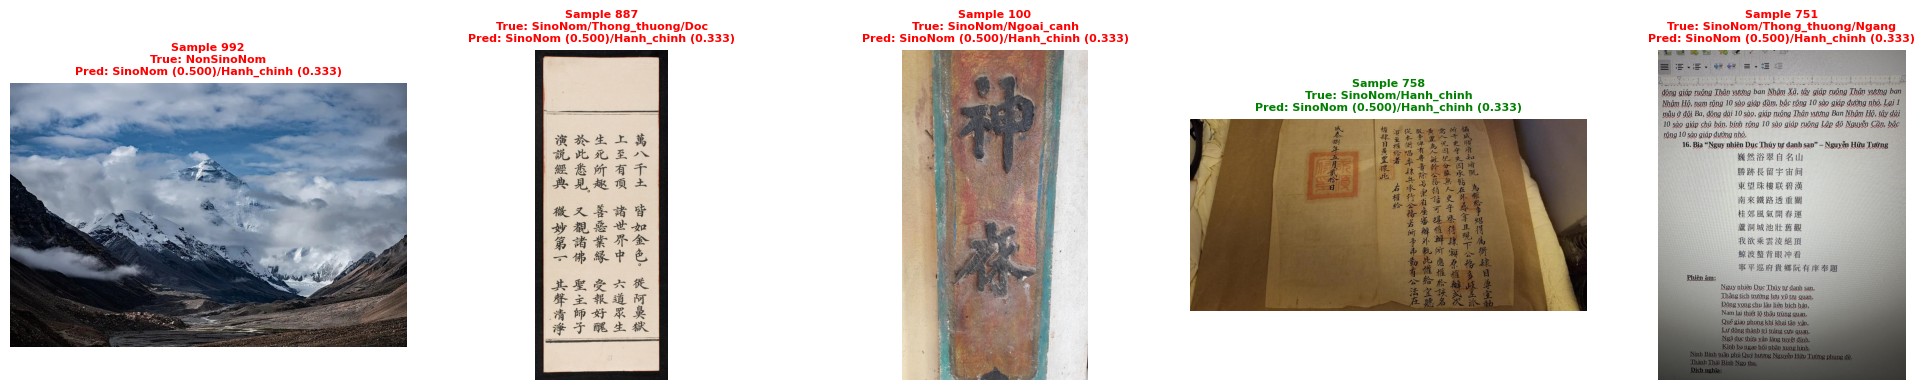


📊 Sample testing completed và saved to outputs/sample_predictions.png


In [15]:
def test_model_on_samples(model, test_df, num_samples=5):
    """
    Test model trên một số sample images và visualize kết quả.
    """
    print(f"🧪 Testing model on {num_samples} sample images...")
    
    # Create inference function
    predict_fn = create_inference_function(model)
    
    # Sample random images from test set
    sample_indices = np.random.choice(len(test_df), min(num_samples, len(test_df)), replace=False)
    
    fig, axes = plt.subplots(1, min(num_samples, 5), figsize=(20, 4))
    if num_samples == 1:
        axes = [axes]
    
    for i, idx in enumerate(sample_indices[:5]):  # Limit to 5 for display
        if i >= len(axes):
            break
            
        # Get sample info
        sample = test_df.iloc[idx]
        img_path = sample['file_path']
        
        # True labels
        true_main = INV_MAIN_CATEGORIES[sample['main_category']]
        true_doc = INV_DOC_TYPES[sample['doc_type']] if sample['main_category'] == MAIN_CATEGORIES['SinoNom'] else 'N/A'
        true_text = INV_TEXT_DIRECTIONS[sample['text_direction']] if (sample['main_category'] == MAIN_CATEGORIES['SinoNom'] and sample['doc_type'] == DOC_TYPES['Thong_thuong']) else 'N/A'
        
        # Predict
        prediction = predict_fn(img_path, return_probabilities=True)
        
        if prediction:
            # Load và display image
                image = Image.open(img_path)
                if image.mode != 'RGB':
                    image = image.convert('RGB')
                axes[i].imshow(image)
                axes[i].axis('off')
                
                # Create title với predictions
                title = f"Sample {idx}\n"
                title += f"True: {true_main}"
                if true_doc != 'N/A':
                    title += f"/{true_doc}"
                if true_text != 'N/A':
                    title += f"/{true_text}"
                
                title += f"\nPred: {prediction['main_category']} ({prediction['main_category_confidence']:.3f})"
                if prediction['document_type'] != 'N/A':
                    title += f"/{prediction['document_type']} ({prediction['document_type_confidence']:.3f})"
                if prediction['text_direction'] != 'N/A':
                    title += f"/{prediction['text_direction']} ({prediction['text_direction_confidence']:.3f})"
                
                # Color code: green for correct, red for incorrect
                correct_main = (prediction['main_category'] == true_main)
                correct_doc = (prediction['document_type'] == true_doc)
                correct_text = (prediction['text_direction'] == true_text)
                
                if correct_main and correct_doc and correct_text:
                    color = 'green'
                else:
                    color = 'red'
                
                axes[i].set_title(title, fontsize=8, color=color, weight='bold')
                
                # Print detailed results
                print(f"\n📋 Sample {idx} Results:")
                print(f"   📁 File: {os.path.basename(img_path)}")
                print(f"   ✅ True: {true_main}/{true_doc}/{true_text}")
                print(f"   🎯 Pred: {prediction['main_category']}/{prediction['document_type']}/{prediction['text_direction']}")
                print(f"   📊 Confidences: {prediction['main_category_confidence']:.3f}/{prediction['document_type_confidence']:.3f}/{prediction['text_direction_confidence']:.3f}")
                print(f"   🎨 Status: {'✅ CORRECT' if color == 'green' else '❌ INCORRECT'}")
        else:
            axes[i].text(0.5, 0.5, f"Prediction failed\n{os.path.basename(img_path)}", 
                       ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(sample_indices), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_PATH}/sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Sample testing completed và saved to {OUTPUT_PATH}/sample_predictions.png")

def demonstrate_hierarchical_logic():
    """
    Demonstrate hierarchical classification logic.
    """
    print("📚 HIERARCHICAL CLASSIFICATION LOGIC DEMONSTRATION")
    print("=" * 60)
    
    print("\n🏗️ Cấu trúc Phân cấp:")
    print("\n📊 Level 1 - Main Category:")
    for name, idx in MAIN_CATEGORIES.items():
        print(f"   {idx}: {name}")
    
    print("\n📋 Level 2 - Document Type (chỉ cho SinoNom):")
    for name, idx in DOC_TYPES.items():
        print(f"   {idx}: {name}")
    
    print("\n📐 Level 3 - Text Direction (chỉ cho Thong_thuong):")
    for name, idx in TEXT_DIRECTIONS.items():
        print(f"   {idx}: {name}")
    
    print("\n🔄 Logic Flow:")
    print("   1️⃣ Tất cả images → Level 1 (SinoNom vs NonSinoNom)")
    print("   2️⃣ Nếu SinoNom → Level 2 (Thong_thuong vs Hanh_chinh vs Ngoai_canh)")
    print("   3️⃣ Nếu Thong_thuong → Level 3 (Doc vs Ngang)")
    
    print("\n📈 Training Strategy:")
    print("   🎯 Conditional Loss: Loss chỉ tính cho samples thỏa mãn điều kiện")
    print("   🔗 Feature Sharing: Level cao sử dụng features từ level thấp")
    print("   ⚖️ Hierarchical Loss: Layer loss + Dependence loss")
    
    print("\n✅ Model đã sẵn sàng để classify tài liệu Hán Nôm theo cấu trúc phân cấp!")

# ==================== SAMPLE TESTING SECTION ====================

if 'model' in locals() and 'test_df' in locals():
    print("\n🧪 SAMPLE TESTING AVAILABLE")
    print("=" * 40)
    
    # Demonstrate hierarchical logic
    # demonstrate_hierarchical_logic()
    
    print("\n📝 Uncomment code below để test model trên sample images:")
    
    # ========== UNCOMMENT TO TEST SAMPLES ==========
    test_model_on_samples(model, test_df, num_samples=20)
    # ===============================================

In [16]:
# 🧪 EVALUATE MODEL ON TEST SET
print("🚀 Starting model evaluation...")

model, model_info = load_trained_model(f'models/final_hierarchical_model.pth')

# Call evaluate_model function
evaluation_results = evaluate_model(model, test_loader)

print("\n📊 EVALUATION COMPLETED!")
print(f"📈 Average Test Loss: {evaluation_results['avg_loss']:.4f}")

# Display summary of results
print("\n📋 EVALUATION SUMMARY:")
for level_key, results in evaluation_results['detailed_results'].items():
    level_num = level_key.split('_')[1]
    level_names = ['Main Category', 'Document Type', 'Text Direction']
    level_name = level_names[int(level_num) - 1]
    
    print(f"   📌 {level_name}: Accuracy = {results['accuracy']:.4f} ({len(results['predictions'])} samples)")

print("\n✅ Evaluation results are now stored in 'evaluation_results' variable")
print("💡 You can now use:")
print("   - plot_confusion_matrices(evaluation_results)")
print("   - save_evaluation_report(evaluation_results)")

🚀 Starting model evaluation...
📂 Loading model from models/final_hierarchical_model.pth...
✅ Model loaded successfully!
🧪 Evaluating model on test set...
✅ Model loaded successfully!
🧪 Evaluating model on test set...


📊 Evaluating: 100%|██████████| 34/34 [00:50<00:00,  1.50s/it]


📊 Test Results:
   💔 Average Loss: 0.5677

📋 Main Category (Level 1):
   🎯 Accuracy: 0.9195
   📊 Samples evaluated: 1068
   📈 Precision: 0.9227
   📈 Recall: 0.9195
   📈 F1-Score: 0.9201

📋 Document Type (Level 2):
   🎯 Accuracy: 0.9778
   📊 Samples evaluated: 677
   📈 Precision: 0.9778
   📈 Recall: 0.9778
   📈 F1-Score: 0.9778

📋 Text Direction (Level 3):
   🎯 Accuracy: 1.0000
   📊 Samples evaluated: 258
   📈 Precision: 1.0000
   📈 Recall: 1.0000
   📈 F1-Score: 1.0000

📊 EVALUATION COMPLETED!
📈 Average Test Loss: 0.5677

📋 EVALUATION SUMMARY:
   📌 Main Category: Accuracy = 0.9195 (1068 samples)
   📌 Document Type: Accuracy = 0.9778 (677 samples)
   📌 Text Direction: Accuracy = 1.0000 (258 samples)

✅ Evaluation results are now stored in 'evaluation_results' variable
💡 You can now use:
   - plot_confusion_matrices(evaluation_results)
   - save_evaluation_report(evaluation_results)


🧪 Testing model on 20 sample images...


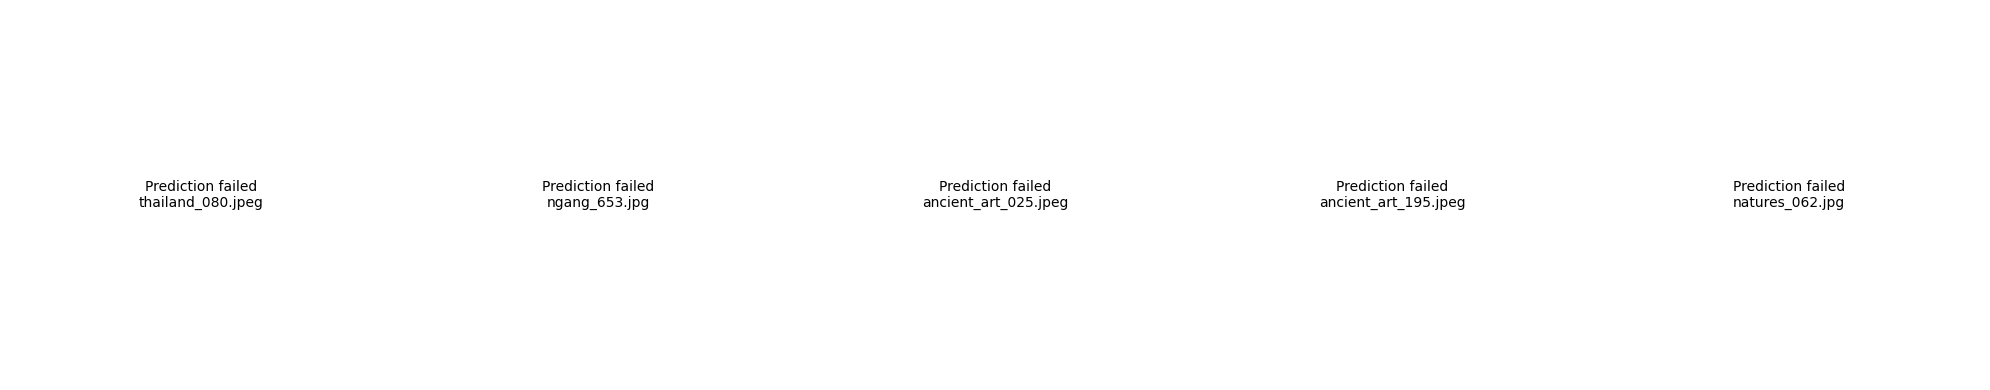


📊 Sample testing completed và saved to outputs/sample_predictions.png


In [13]:
test_model_on_samples(model, test_df, num_samples=20)

In [1]:
# 🖼️ INTERACTIVE IMAGE CLASSIFIER FROM YOUR COMPUTER
import tkinter as tk
from tkinter import filedialog
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F

def select_and_classify_image():
    """
    Hàm để chọn và phân loại hình ảnh từ máy tính của bạn.
    """
    print("🖼️ INTERACTIVE HÁN NÔM IMAGE CLASSIFIER")
    print("=" * 50)
    
    # Tạo cửa sổ để chọn file (ẩn cửa sổ chính)
    root = tk.Tk()
    root.withdraw()  # Ẩn cửa sổ chính
    
    # Mở hộp thoại chọn file
    print("📁 Đang mở cửa sổ chọn file...")
    file_path = filedialog.askopenfilename(
        title="Chọn hình ảnh Hán Nôm để phân loại",
        filetypes=[
            ("Image files", "*.jpg *.jpeg *.png *.bmp *.tiff *.tif"),
            ("JPEG files", "*.jpg *.jpeg"),
            ("PNG files", "*.png"),
            ("All files", "*.*")
        ]
    )
    
    # Đóng cửa sổ tkinter
    root.destroy()
    
    if not file_path:
        print("❌ Không có file nào được chọn!")
        return None
    
    print(f"✅ Đã chọn file: {os.path.basename(file_path)}")
    
    # Kiểm tra file tồn tại
    if not os.path.exists(file_path):
        print("❌ File không tồn tại!")
        return None
    
    # Tạo inference function
    predict_fn = create_inference_function(model)
    
    try:
        # Thực hiện phân loại
        print("🧠 Đang phân loại hình ảnh...")
        prediction = predict_fn(file_path, return_probabilities=True)
        
        if prediction is None:
            print("❌ Không thể phân loại hình ảnh này!")
            return None
        
        # Load và hiển thị hình ảnh
        image = Image.open(file_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Tạo visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Hiển thị hình ảnh gốc
        ax1.imshow(image)
        ax1.axis('off')
        ax1.set_title(f"Original Image\n{os.path.basename(file_path)}", fontsize=12, weight='bold')
        
        # Tạo kết quả phân loại
        result_text = "🏛️ KẾT QUẢ PHÂN LOẠI HÁN NÔM\n\n"
        
        # Level 1: Main Category
        main_cat = prediction['main_category']
        main_conf = prediction['main_category_confidence']
        result_text += f"📊 LOẠI CHÍNH: {main_cat}\n"
        result_text += f"   Độ tin cậy: {main_conf:.1%}\n\n"
        
        # Level 2: Document Type (nếu là SinoNom)
        if prediction['document_type'] != 'N/A':
            doc_type = prediction['document_type']
            doc_conf = prediction['document_type_confidence']
            result_text += f"📋 LOẠI TÀI LIỆU: {doc_type}\n"
            result_text += f"   Độ tin cậy: {doc_conf:.1%}\n\n"
        else:
            result_text += f"📋 LOẠI TÀI LIỆU: Không áp dụng\n\n"
        
        # Level 3: Text Direction (nếu là Thong_thuong)
        if prediction['text_direction'] != 'N/A':
            text_dir = prediction['text_direction']
            text_conf = prediction['text_direction_confidence']
            result_text += f"📐 HƯỚNG ĐỌC: {text_dir}\n"
            result_text += f"   Độ tin cậy: {text_conf:.1%}\n\n"
        else:
            result_text += f"📐 HƯỚNG ĐỌC: Không áp dụng\n\n"
        
        # Thêm thông tin về xác suất chi tiết
        if 'raw_probabilities' in prediction:
            probs = prediction['raw_probabilities']
            result_text += "📈 CHI TIẾT XÁC SUẤT:\n"
            result_text += f"Level 1: {[f'{p:.3f}' for p in probs['level_1']]}\n"
            result_text += f"Level 2: {[f'{p:.3f}' for p in probs['level_2']]}\n"
            result_text += f"Level 3: {[f'{p:.3f}' for p in probs['level_3']]}\n"
        
        # Hiển thị kết quả bên phải
        ax2.text(0.05, 0.95, result_text, transform=ax2.transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')
        ax2.set_title("Classification Results", fontsize=12, weight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # In kết quả ra console
        print("\n" + "="*60)
        print("🎯 KẾT QUẢ PHÂN LOẠI")
        print("="*60)
        print(f"📁 File: {os.path.basename(file_path)}")
        print(f"📊 Loại chính: {main_cat} ({main_conf:.1%})")
        
        if prediction['document_type'] != 'N/A':
            print(f"📋 Loại tài liệu: {doc_type} ({doc_conf:.1%})")
        else:
            print(f"📋 Loại tài liệu: Không áp dụng")
            
        if prediction['text_direction'] != 'N/A':
            print(f"📐 Hướng đọc: {text_dir} ({text_conf:.1%})")
        else:
            print(f"📐 Hướng đọc: Không áp dụng")
            
        print("="*60)
        
        return prediction
        
    except Exception as e:
        print(f"❌ Lỗi khi phân loại: {str(e)}")
        return None

def classify_multiple_images():
    """
    Hàm để chọn và phân loại nhiều hình ảnh cùng lúc.
    """
    print("🖼️ PHÂN LOẠI NHIỀU HÌNH ẢNH")
    print("=" * 50)
    
    # Tạo cửa sổ để chọn file
    root = tk.Tk()
    root.withdraw()
    
    # Mở hộp thoại chọn nhiều file
    print("📁 Đang mở cửa sổ chọn nhiều file...")
    file_paths = filedialog.askopenfilenames(
        title="Chọn nhiều hình ảnh Hán Nôm để phân loại",
        filetypes=[
            ("Image files", "*.jpg *.jpeg *.png *.bmp *.tiff *.tif"),
            ("JPEG files", "*.jpg *.jpeg"),
            ("PNG files", "*.png"),
            ("All files", "*.*")
        ]
    )
    
    root.destroy()
    
    if not file_paths:
        print("❌ Không có file nào được chọn!")
        return []
    
    print(f"✅ Đã chọn {len(file_paths)} file(s)")
    
    # Tạo inference function
    predict_fn = create_inference_function(model)
    
    results = []
    
    # Phân loại từng hình ảnh
    for i, file_path in enumerate(file_paths, 1):
        print(f"\n🔄 Đang xử lý {i}/{len(file_paths)}: {os.path.basename(file_path)}")
        
        try:
            prediction = predict_fn(file_path, return_probabilities=True)
            if prediction:
                results.append({
                    'file_path': file_path,
                    'file_name': os.path.basename(file_path),
                    'prediction': prediction
                })
                print(f"   ✅ {prediction['main_category']} -> {prediction['document_type']} -> {prediction['text_direction']}")
            else:
                print(f"   ❌ Không thể phân loại")
                
        except Exception as e:
            print(f"   ❌ Lỗi: {str(e)}")
    
    # Hiển thị tóm tắt kết quả
    if results:
        print(f"\n📊 TÓM TẮT KẾT QUẢ ({len(results)} hình ảnh):")
        print("-" * 60)
        
        for i, result in enumerate(results, 1):
            pred = result['prediction']
            print(f"{i:2d}. {result['file_name']}")
            print(f"     {pred['main_category']} -> {pred['document_type']} -> {pred['text_direction']}")
    
    return results

# Hiển thị hướng dẫn sử dụng
print("🎯 HƯỚNG DẪN SỬ DỤNG:")
print("=" * 50)
print("📌 Để phân loại 1 hình ảnh:")
print("   result = select_and_classify_image()")
print()
print("📌 Để phân loại nhiều hình ảnh:")
print("   results = classify_multiple_images()")
print()
print("✅ Các hàm đã sẵn sàng để sử dụng!")
print("💡 Chạy lệnh bên trên để bắt đầu chọn và phân loại hình ảnh từ máy tính của bạn.")

🎯 HƯỚNG DẪN SỬ DỤNG:
📌 Để phân loại 1 hình ảnh:
   result = select_and_classify_image()

📌 Để phân loại nhiều hình ảnh:
   results = classify_multiple_images()

✅ Các hàm đã sẵn sàng để sử dụng!
💡 Chạy lệnh bên trên để bắt đầu chọn và phân loại hình ảnh từ máy tính của bạn.


🚀 DEMO: Chọn và phân loại hình ảnh từ máy tính
🖼️ INTERACTIVE HÁN NÔM IMAGE CLASSIFIER
📁 Đang mở cửa sổ chọn file...
✅ Đã chọn file: Screenshot 2025-08-10 at 04.30.18.png
🧠 Đang phân loại hình ảnh...
✅ Đã chọn file: Screenshot 2025-08-10 at 04.30.18.png
🧠 Đang phân loại hình ảnh...


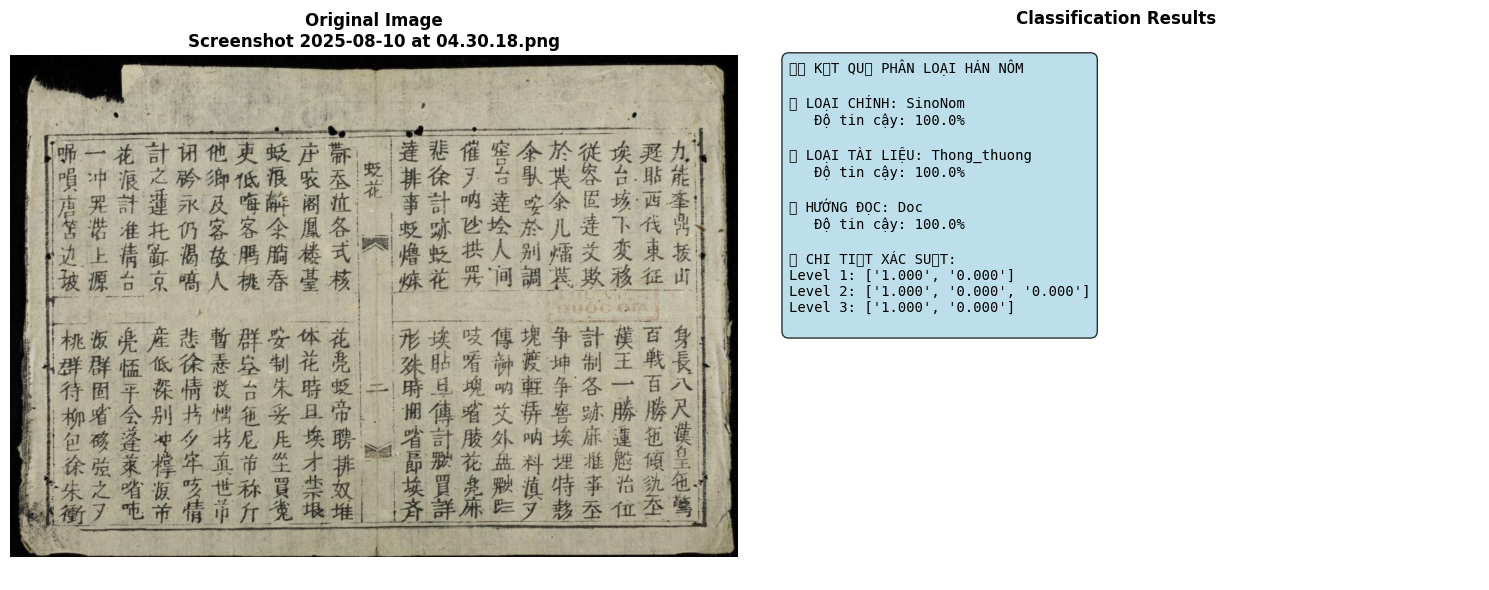


🎯 KẾT QUẢ PHÂN LOẠI
📁 File: Screenshot 2025-08-10 at 04.30.18.png
📊 Loại chính: SinoNom (100.0%)
📋 Loại tài liệu: Thong_thuong (100.0%)
📐 Hướng đọc: Doc (100.0%)


: 

In [ ]:
# 🚀 SỬ DỤNG INTERACTIVE IMAGE CLASSIFIER
print("🚀 DEMO: Chọn và phân loại hình ảnh từ máy tính")

# Uncomment dòng bên dưới để chọn và phân loại 1 hình ảnh:
result = select_and_classify_image()

# Uncomment dòng bên dưới để chọn và phân loại nhiều hình ảnh:
# results = classify_multiple_images()